<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация чисел на основе базы MNIST

[Есть код](http://s6957389.stat-pulse.com/go/ec/a21e199f15c6b8797d6383824bc052e1/ci/OTA4ODc0Mw==/ui/Njk1NzM4OQ==/li/MjA4MDQzNTQx/re/aWZuZGVmQHlhbmRleC5ydQ==/l/aHR0cHMlM0ElMkYlMkZ3d3cuZHJvcGJveC5jb20lMkZzJTJGMmV5cmg3YmNqbXVuY2pjJTJGZ2VuZXJhdGl2ZTEuemlwJTNGZGwlM0Qw/) обычной генеративной сети. Сделать на основе него генерацию с условием на той же базе MNIST. Значит, для генерации мы подаем не только вектор шума, но и число от 0 до 9 (one-hot вектор) – на вход и генератору, и дискриминатору. 
 

## Подготовка окружения

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import sys
import datetime
import imageio

import numpy as np

### Входные данные

In [0]:
num_classes = 10
target_number = 4
target_vector = to_categorical(target_number, num_classes = num_classes)

epochs = 1000
sample_interval = 200
log_interval = 100
latent_dim = 10

### Папка для выходных данных

In [0]:
folder_name = "gen_%s" % target_number
print(folder_name)
!rm -fr {folder_name}
!mkdir {folder_name}

images


In [43]:
batch_size = 128
a = [1, 5, 3]
b = to_categorical(a)
print(b)

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]


 ## Генеративная нейросеть

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        self.noise_shape = (self.latent_dim,)
        self.labels_shape = (num_classes,)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
#         self.discriminator = self.build_discriminator()
#         self.discriminator.compile(loss='binary_crossentropy',
#             optimizer=optimizer,
#             metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

#         # The generator takes noise as input and generates imgs
#         z = Input(shape=(self.latent_dim,))
#         img = self.generator(z)

#         # For the combined model we will only train the generator
#         self.discriminator.trainable = False

#         # The discriminator takes generated images as input and determines validity
#         validity = self.discriminator(img)

#         # The combined model  (stacked generator and discriminator)
#         # Trains the generator to fool the discriminator
#         self.combined = Model(z, validity)
#         self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        print("\n----- Generator -----\n")

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))        
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.input_dim,))
        labels = Input(shape=label_shape, name='class_labels')

        img = model(noise, labels)

        return Model(noise, img)

    def build_discriminator(self):
        print("\n----- Discriminator -----\n")

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Concatenate([noise_shape, labels_shape], axis=1))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


In [49]:
from keras.layers.merge import Concatenate

class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100

    self.noise_shape = (self.latent_dim,)
    self.labels_shape = (num_classes,)

    optimizer = Adam(0.0002, 0.5)

#   Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

#         # The generator takes noise as input and generates imgs
#         z = Input(shape=(self.latent_dim,))
#         img = self.generator(z)

#         # For the combined model we will only train the generator
#         self.discriminator.trainable = False

#         # The discriminator takes generated images as input and determines validity
#         validity = self.discriminator(img)

#         # The combined model  (stacked generator and discriminator)
#         # Trains the generator to fool the discriminator
#         self.combined = Model(z, validity)
#         self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


  def build_generator(self):
    print("\n----- Generator -----\n")

    # Input
    noise_input = Input(self.noise_shape)
    label_input = Input(self.labels_shape)
    concat_layer= Concatenate()([noise_input, label_input])
    
    # Layers
    x = Dense(256, input_dim=self.latent_dim + 10)(concat_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Dense(np.prod(self.img_shape), activation='tanh')(x)
    x = Reshape(self.img_shape)(x)
    
    generator = Model(inputs = [noise_input, label_input], outputs = x, name='generator')
    generator.summary()
    return generator
    
  def build_discriminator(self):
    print("\n----- Discriminator -----\n")

    # Input
    image_input = Input(self.img_shape)
    label_input = Input(self.labels_shape)
    
    # Layers
    x = Flatten(input_shape=self.img_shape)(image_input)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Concatenate()([x, label_input])
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs = [image_input, label_input], outputs = x, name="discriminator")
    discriminator.summary()
    return discriminator
  
  def train(self, target, epochs, batch_size=128, sample_interval=50):
    target = to_categorical(target)
    
    # Load the dataset
    (X_train, Y_train), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    fake_labels = np.repeat((batch_size, target_vector))

    for epoch in range(epochs):

      # ---------------------
      #  Train Discriminator
      # ---------------------

      # Select a random batch of images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
      labels = to_categorical(Y_train[idx])

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Generate a batch of new images
      gen_imgs = self.generator.predict([noise, target_vector])

      # Train the discriminator
      d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
      d_loss_fake = self.discriminator.train_on_batch([gen_imgs, fake_labels], fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # ---------------------
      #  Train Generator
      # ---------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Train the generator (to have the discriminator label samples as valid)
      g_loss = self.combined.train_on_batch(noise, valid)

      # Plot the progress
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

      # If at save interval => save generated image samples
      if epoch % sample_interval == 0:
          self.sample_images(epoch, target_vector)

  def sample_images(self, epoch, target_vector):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict([noise, target_vector])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()


gan = GAN()
gan.discriminator.summary()


----- Discriminator -----

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 784)          0           input_28[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 512)          401920      flatten_7[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_31 (LeakyReLU)      (None, 512)          0           dense_44[0][0]                   
_________________________________________________________________________________

## Обучение сети

In [24]:
gan = GAN()
# gan.train(epochs=epochs, batch_size=32, sample_interval=sample_interval)



----- Generator -----



NameError: ignored

## Визуализация результата

### Генерация GIF

In [0]:
def folder_to_gif(folder, output_file):
  images = []
  for index in np.arange(0, epochs, sample_interval):
    images.append(imageio.imread("%s/%s.png" % (folder, index)))
  
  imageio.mimsave(output_file, images)

In [0]:
# print(np.arange(0, epochs, sample_interval))
output_file = 'training-%s-%s.gif' % (target_number, datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))
folder_to_gif(folder_name, output_file)

### Результат работы генератора

gen_4/10000.png


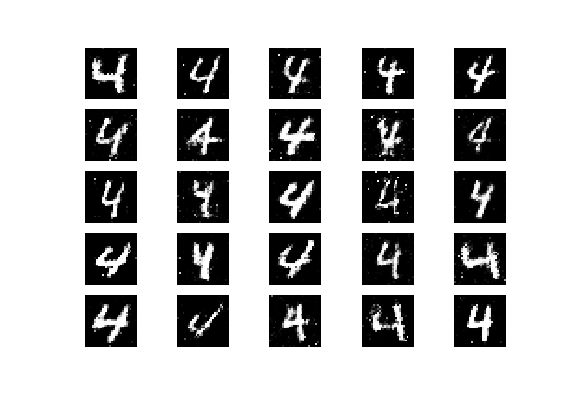

In [0]:
last_file = "%s/%s.png" % (folder_name, epochs)
print(last_file)

with open(last_file,'rb') as f:
    display(Image(data=f.read(), format='png'))